*Think Linear Algebra* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

# Truss in the System

In this chapter, we'll use systems of linear equations to analyze trusses.

A **truss** is an assembly of beams connected by joints, usually designed to support a load. Many bridges and roofs are supported by trusses, and if you've ever participated in a model bridge competition, the structure you built was probably a truss.

This picture shows a **Warren truss**, the basis of many railroad bridge designs:

<img width="400" src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/VIEW_OF_BRIDGE_FROM_SOUTH_WITH_ONCOMING_CSX_LOCOMOTIVE_ON_TRACKS_BELOW%2C_LOOKING_NORTHEAST_-_Wills_Creek_Bollman_Bridge%2C_Spanning_CSX_tracks_at_T381%2C_Meyersdale%2C_Somerset_County%2C_HAER_PA%2C56-MEYER.V%2C2-2.tif/lossy-page1-800px-thumbnail.tif.jpg">

This structure is made of three connected triangles with horizontal beams across the top. It's supported by anchor points at each end, and it carries a deck that supports a roadway. The load on the truss includes the weight of the roadway, any vehicles on it, and the weight of the truss itself.

To model a structure like this, we'll make some simplifying assumptions:

- We'll treat the structure as two-dimensional, analyzing only one side of the truss.

- We'll assume the joints behave like **hinge pins** that connect members but allow them to rotate freely.

- We'll assume the load is applied only at the joints, not along the length of the members.

- We'll treat each member of the truss as a **spring** that pushes or pulls in response to stretching or compression, with force that depends on its size and material.

- We'll assume that the stretching and compression are small enough that the geometry of the truss is unchanged. 

These assumptions aren't fully realistic, but they're reasonable approximations.
With them, we can analyze the structure -- that is, for a given load, we can compute how much each member stretches or compresses, and how much force it exerts in response.

The goal is to find an **equilibrium**, where the external forces applied to the truss are exactly balanced by internal spring forces in the members.

To solve this system, we'll use **projection matrices**, which we saw in Section XXX, and we'll introduce **block matrices**, which are matrices that contain vectors or submatrices as elements.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkLinearAlgebra/blob/main/nb/nullspace.ipynb).

In [84]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkLinearAlgebra/raw/main/utils.py")

In [86]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp

from utils import decorate, underride

## The Simplest Truss

We'll start with a truss that's about as simple as it can be, shown in the following diagram.

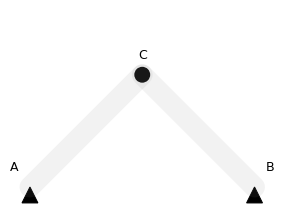

In [87]:
from utils import diagram_truss

# Define endpoints of truss members (undisplaced)
l = 0.15
lower_left = np.array([-l, -l])   
lower_right = np.array([l, -l])   
top = np.array([0, 0])
nodes = lower_left, lower_right, top

diagram_truss(nodes, add_vectors=False)

lim = 1.2 * l
plt.xlim(-lim, lim)
plt.ylim(-lim, lim/2)
plt.gca().set_aspect('equal')
plt.axis('off')
None

The truss contains only two elements.
The one on the left is anchored at point A, the one on the right is anchored at point B, and they are connected to each other at point C.

The triangles represent anchors holding the points A and B in place.
The circle represents a pin joint that can move under load.

To start the analysis of this truss, we'll define symbols to represent the starting position of point C in two dimensions.

In [114]:
from sympy import symbols

x_C, y_C = symbols('x_C y_C')

And two more symbols to represent the displacement of point C from its starting position.
These are the unknowns we will solve for.

In [115]:
u_x, u_y = symbols('u_x u_y')

It will convenient to pack these unknowns into a column vector.

In [116]:
from sympy import Matrix

u_C = Matrix([u_x, u_y])
u_C

Matrix([
[u_x],
[u_y]])

Similarly, we'll create matrices to represent the starting positions of points A, B, and C, based on `L`, which represents the length of one of the elements of the truss.

In [117]:
L = symbols('L')
pos_A = Matrix([0, 0])
pos_B = Matrix([L, 0])
pos_C = Matrix([x_C, y_C])

Next we'll compute the spring constant of the two elements, which is the product of the cross-sectional area, `A`, and the Young's modulus, `E`, divided by length `L`.

For this example, we'll assume that the cross-sectional area is the same but not necessarily the Young's modulus.
Here are the symbols we need:

In [118]:
A = symbols('A')
E_CA, E_CB = symbols('E_CA E_CB')

And the spring constants:

In [119]:
k_CA = E_CA * A / L
k_CB = E_CB * A / L

display(k_CA, k_CB)

A*E_CA/L

A*E_CB/L

Next we'll compute vectors that represent the offset of A and B, relative to C.

In [120]:
r_CA = pos_A - pos_C
r_CB = pos_B - pos_C

Now, to compute the spring forces in the elements, we have to figure out what part of the displacement, `u`, is along the axis of each element.
We can do that by computing the vector projection of `u` onto `r_CA` and `r_CB`, as shown in this diagram.

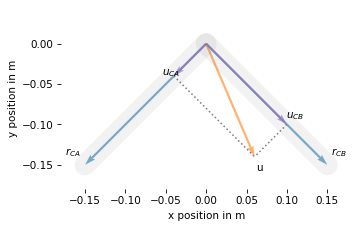

In [121]:
from utils import plot_vector, remove_spines

plt.figure(figsize=(5, 5))

u = np.array([3, -7]) * 1e-6
scale = 2e4

diagram_truss(nodes, u*scale, add_pin=False, add_labels=False)

plt.xlim(-lim, lim)
plt.ylim(-lim, lim/4)

plt.xlabel('x position in m')
plt.ylabel('y position in m')
plt.title('')
remove_spines()

To compute the vector projection, we'll use this function, which:

1. Computes the unit vector in the direction of `r`, called `r_hat`,

2. Computes `r_hat.T * u`, which is the scalar magnitude of `u` in the direction of `r_hat`, and

3. Multiplies the result by `r_hat`.

The result is a vector that represents the component of `u` in the direction of `r`. 

In [158]:
def vector_projection(u, r):
    r_hat = r.normalized()
    scalar_projection = r_hat.T * u
    return r_hat * scalar_projection

To compute the spring forces in the elements, we multiply the spring constants by the scalar projections.

In [159]:
f_CA = -k_CA * vector_projection(u_C, r_CA)
f_CB = -k_CB * vector_projection(u_C, r_CB)

As an example, here's `f_CA`, which is a force vector.

In [160]:
f_CA

Matrix([
[A*E_CA*x_C*(-u_x*x_C/sqrt(Abs(x_C)**2 + Abs(y_C)**2) - u_y*y_C/sqrt(Abs(x_C)**2 + Abs(y_C)**2))/(L*sqrt(Abs(x_C)**2 + Abs(y_C)**2))],
[A*E_CA*y_C*(-u_x*x_C/sqrt(Abs(x_C)**2 + Abs(y_C)**2) - u_y*y_C/sqrt(Abs(x_C)**2 + Abs(y_C)**2))/(L*sqrt(Abs(x_C)**2 + Abs(y_C)**2))]])

The total force due to the compression of these elements is the sum of the spring forces.

In [161]:
f_int = f_CA + f_CB

Let's suppose that the external force at `C` is a weight that pulls down in the `y` direction, with no additional force in the `x` direction.

In [162]:
F = symbols('F')
f_ext = Matrix([0, -F])

If the truss is not moving, the internal and external forces must be equal, so we can write this equation, which relates the external force to the spring forces.

In [163]:
eq = sp.Eq(f_int, f_ext)
eq

Eq(Matrix([
[A*E_CA*x_C*(-u_x*x_C/sqrt(Abs(x_C)**2 + Abs(y_C)**2) - u_y*y_C/sqrt(Abs(x_C)**2 + Abs(y_C)**2))/(L*sqrt(Abs(x_C)**2 + Abs(y_C)**2)) - A*E_CB*(L - x_C)*(u_x*(L - x_C)/sqrt(Abs(y_C)**2 + Abs(L - x_C)**2) - u_y*y_C/sqrt(Abs(y_C)**2 + Abs(L - x_C)**2))/(L*sqrt(Abs(y_C)**2 + Abs(L - x_C)**2))],
[      A*E_CA*y_C*(-u_x*x_C/sqrt(Abs(x_C)**2 + Abs(y_C)**2) - u_y*y_C/sqrt(Abs(x_C)**2 + Abs(y_C)**2))/(L*sqrt(Abs(x_C)**2 + Abs(y_C)**2)) + A*E_CB*y_C*(u_x*(L - x_C)/sqrt(Abs(y_C)**2 + Abs(L - x_C)**2) - u_y*y_C/sqrt(Abs(y_C)**2 + Abs(L - x_C)**2))/(L*sqrt(Abs(y_C)**2 + Abs(L - x_C)**2))]]), Matrix([
[ 0],
[-F]]))

To analyze the truss, we want to find the displacement `u` that solves this equation.
First, let's plug in values for the symbols.

For `L`, we'll use the length of a popsicle stick in centimeters, and compute the location of `x_C` and `y_C` accordingly.

The cross-sectional area, `A`, is based on the approximate width and thickness of a popsicle stick.

The Young's modulus of wood is about 3 gigapascal.

Finally, let's suppose the external force is the weight of a one kilogram mass, which is roughly 9.8 N.

In [164]:
import pint
ureg = pint.UnitRegistry()

params = {
    'L': 15.0 * ureg.cm,
    'x_C': 15.0 / 2 * ureg.cm,
    'y_C': np.sqrt(3) * 15.0 / 2 * ureg.cm,
    'A': 1.0 * ureg.cm * 0.2 * ureg.cm,
    'E_CA': 3.0e9 * ureg.Pa,
    'E_CB': 2.0e9 * ureg.Pa,
    'F': 9.8 * ureg.newton,
}

To substitute these values into the equation, we'll use this function, which makes a dictionary to map from symbols to their values.

In [165]:
def make_subs(symbols, params):
    """Make a dictionary that maps from symbols to quantities."""
    return {sym: params[sym.name].to_base_units().magnitude 
            for sym in symbols}

Now we can express the equation numerically.

In [166]:
syms = [L, x_C, y_C, A, E_CA, E_CB, F]
subs = make_subs(syms, params)

eqs_num = eq.subs(subs)
eqs_num

Eq(Matrix([
[-166666.666666667*u_x - 57735.0269189626*u_y],
[        -57735.0269189626*u_x - 500000.0*u_y]]), Matrix([
[   0],
[-9.8]]))

In [167]:
from sympy import solve

sol = solve(eqs_num, (u_x, u_y))
sol

{u_x: -7.07254079757292e-6, u_y: 2.04166666666667e-5}

## The Stiffness Mutrix

In the previous section, we wrote a vector equation with external force on the right and internal force on the left.
The SciPy `solve` function can solve the equation in this form, so it's sufficient to analyze the truss.  [TODO: Does solve have to rewrite it us a matrix equation?]

To write the left side us a matrix-vector product, we could factor out `u_x` and `u_y`.
Or we can go back and write it that way in the first place.
To do that, let's rethink the scalar projection.

$$\mathrm{proj}_{r} u = \hat{r}\, \hat{r}^T u$$


In `vector_projection`, we computed the scalar projection `r_hat.T u` first, to get the magnitude of the projection of `u` in the direction of `r`, and then multiplied by `r_hat`.
In other words, we evaluated the vector projection like this:

$$\mathrm{proj}_{r} u = \hat{r}\, (\hat{r}^T u)$$

As an alternative, we could have multiplied `r_hat` and `r_hat.T` first, like this:

$$\mathrm{proj}_{r} u = (\hat{r}\, \hat{r}^T) u$$

If `r_hat` is a column vector, the product of `r_hat` and `r_hat.T` is a matrix called a **projector**, which we can compute like this.

In [168]:
def projector(r):
    rhat = r.normalized()
    return rhat * rhat.T

As an example, here's the projector matrix for the vector `r_CA`.

In [172]:
P_CA = projector(r_CA)
P_CA

Matrix([
[ x_C**2/(Abs(x_C)**2 + Abs(y_C)**2), x_C*y_C/(Abs(x_C)**2 + Abs(y_C)**2)],
[x_C*y_C/(Abs(x_C)**2 + Abs(y_C)**2),  y_C**2/(Abs(x_C)**2 + Abs(y_C)**2)]])

Now if we multiply `P_CA` and `u`, the result is the vector projection of `u_C` onto `r_CA`.

In [174]:
P_CA * u_C

Matrix([
[u_x*x_C**2/(Abs(x_C)**2 + Abs(y_C)**2) + u_y*x_C*y_C/(Abs(x_C)**2 + Abs(y_C)**2)],
[u_x*x_C*y_C/(Abs(x_C)**2 + Abs(y_C)**2) + u_y*y_C**2/(Abs(x_C)**2 + Abs(y_C)**2)]])

But let's not combine `P_CA` and `U_C` yet; instead, we'll compute the projector matrix for the other element of the truss, `P_CB`.

In [ ]:
P_CB = projector(r_CB)

If we multiply a projector matrix by the spring constant `k`, the result is a **stiffness matrix**.
So `k_CA * P_CA` is the stiffness matrix due to the truss element `CA` and
`k_CB * P_CB` is the stiffness matrix due to the truss element `CB`.
Their sum is the stiffness matrix for the whole truss, which we'll call `K`.


In [170]:
K = k_CA * P_CA + k_CB * P_CB
K

Matrix([
[  A*E_CA*x_C**2/(L*(Abs(x_C)**2 + Abs(y_C)**2)) + A*E_CB*(L - x_C)**2/(L*(Abs(y_C)**2 + Abs(L - x_C)**2)), A*E_CA*x_C*y_C/(L*(Abs(x_C)**2 + Abs(y_C)**2)) - A*E_CB*y_C*(L - x_C)/(L*(Abs(y_C)**2 + Abs(L - x_C)**2))],
[A*E_CA*x_C*y_C/(L*(Abs(x_C)**2 + Abs(y_C)**2)) - A*E_CB*y_C*(L - x_C)/(L*(Abs(y_C)**2 + Abs(L - x_C)**2)),         A*E_CA*y_C**2/(L*(Abs(x_C)**2 + Abs(y_C)**2)) + A*E_CB*y_C**2/(L*(Abs(y_C)**2 + Abs(L - x_C)**2))]])

To convert `K` to a NumPy array, we'll use the following function.

In [181]:
def sympy_to_numpy(expr, subs):
    return np.array(expr.subs(subs), dtype=float)

Here's `K` in numerical form.

In [182]:
K_np = sympy_to_numpy(K, subs)
K_np

array([[166666.66666667,  57735.02691896],
       [ 57735.02691896, 500000.        ]])

If we multiply `K` by a displacement vector, the result is a force vector that represents the internal force due to that displacement.
So one way to interpret the stiffness matrix is to test it with small displacements.
Here's an example where we displace `C` by one micrometer in the `x` direction.

In [195]:
u_example1 = np.array([1, 0]) * 1e-6
f_example1 = -K_np @ u_example1
f_example1

array([-0.16666667, -0.05773503])

The restoring force is about 0.17 N in the negative `x` direction and 0.057 N in the negative `y` direction.
And here's an example where we displace `C` by one micrometer in the `y` direction.

In [196]:
u_example2 = np.array([0, 1]) * 1e-6
f_example2 = -K_np @ u_example2
f_example2

array([-0.05773503, -0.5       ])

The restoring force is about 0.057 N in the negative `x` direction and 0.5 N in the negative `y` direction.
Comparing the magnitudes of these forces, we can see that this truss is stiffer in the `y` direction than in the `x`, by a factor of almost 3.

In [197]:
from scipy.linalg import norm

norm(f_example2) / norm(f_example1)

2.8535691936340255

In [199]:
F_ext_np = sympy_to_numpy(f_ext, subs)
F_ext_np

array([[ 0. ],
       [-9.8]])

In [202]:
from scipy.linalg import solve as np_solve

np_solve(K_np, F_ext_np)

array([[ 7.07254080e-06],
       [-2.04166667e-05]])

## Force Field

In the previous section, we used the stiffness matrix to compute the internal force that results from small displacements in the `x` and `y` direction.
More generally, we can compute the force that results from any displacement.
To demonstrate, we'll make an array of 9 values from -21 to 21 micrometers.

In [232]:
scale = 1e-6
bound = 20
displacements = np.linspace(-bound, bound, 9) * scale
displacements

array([-2.0e-05, -1.5e-05, -1.0e-05, -5.0e-06,  0.0e+00,  5.0e-06,
        1.0e-05,  1.5e-05,  2.0e-05])

By enumerating all pairs of values, we'll make an array of 81 displacement vectors.

In [233]:
pairs = [(x, y) for x in displacements for y in displacements]
U = np.array(pairs).T 
U.shape

(2, 81)

`U` is matrix-like in the sense that it has two dimensions, but we are using it as a collection of vectors.
If we multiply by the stiffness matrix, we can think of the result as a collection of force vectors.

In [234]:
F_field = -K_np @ U
F_field.shape

(2, 81)

The following figure shows the results.
The location of each arrow shows a hypothetical displacement.
Each arrow shows the direction and relative magnitude of the resulting force due to displacement.
Note that the positions and forces are not in the same units, so the scale of the arrows is arbitrary.

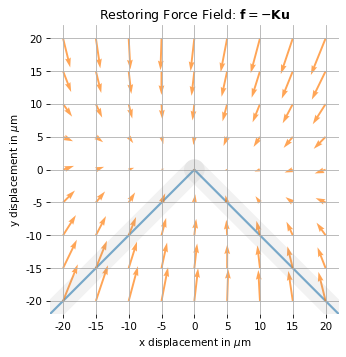

In [240]:
from utils import plot_vectors

plt.figure(figsize=(5, 5))
diagram_truss(nodes, add_pin=False, add_labels=False)

options = dict(angles='xy', scale_units='xy', scale=5e-7)

plot_vectors(F_field.T, U.T, color='C1', alpha=0.7, **options)

plt.gca().set_aspect('equal')

lim = scale * (bound + 2)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

ticks = np.arange(-20, 21, 5)
plt.xticks(displacements, ticks)
plt.yticks(displacements, ticks)

plt.xlabel('x displacement in $\mu$m')
plt.ylabel('y displacement in $\mu$m')
plt.title('Restoring Force Field: $\\mathbf{f} = -\\mathbf{K} \\mathbf{u}$')
plt.grid(True)
None

Multiplication by `K` is like a function: it takes a displacement vector and returns a corresponding force vector.

A function that maps vectors to other vectors is sometimes called a **vector field**.
And when those vectors represent forces, we call it a **force field**.

## Warren Trusses

So far we've been working with a simple truss with only two elements.
It contained only one node that could move, so we could analyze it with a vector equation with only two components.
Now let's try something a little harder -- we'll analyze a Warren truss.
We'll use NetworkX to represent the nodes and elements of the truss.
Then we'll construct a matrix equation that relates the displacements at the nodes to the external forces.

We'll use the following function to create a SymPy `Matrix` that represents a vector.

In [244]:
def make_vector(x, y, **kwargs):
    return sp.ImmutableDenseMatrix([[x], [y]])

And we'll use helper functions `gset` and `gget` to set and get attributes of the nodes and edges in a graph.

TODO: Move these to utils.

In [245]:
def gset(G, item=None, **kwargs):
    """Set attributes on a node, edge, or the graph itself.

    Args:
        G: A NetworkX graph.
        item: Node ID, edge tuple (u, v), or None for the graph itself.
        **kwargs: Arbitrary key-value pairs to set as attributes.
    """
    if item is None:
        container = G.graph
    elif isinstance(item, tuple) and len(item) == 2:
        container = G.edges[item]
    else:
        container = G.nodes[item]

    container.update(**kwargs)

In [246]:
def gget(G, item=None, *keys):
    """Get one or more attributes from a node, edge, or the graph itself.

    Args:
        G: A NetworkX graph.
        item: Node ID, edge tuple (u, v), or None for the graph itself.
        *keys: One or more attribute names.

    Returns:
        A single value if one key is provided, or a tuple of values if multiple.
    """
    if item is None:
        container = G.graph
    elif isinstance(item, tuple) and len(item) == 2:
        container = G.edges[item]
    else:
        container = G.nodes[item]

    if len(keys) == 1:
        return container[keys[0]]
    return tuple(container[key] for key in keys)

To specify the structure of the truss, we'll define `N`, which is the number of triangles in the truss, `L`, which is the length of the elements, and `H`, which is the height of the triangles.
We'll assume that all elements are the same length, so the triangles are equilateral.

In [247]:
N = 2
L = sp.Symbol('L', positive=True)
H = L * sp.sqrt(3) / 2

Now let's make the graph.
To understand the code in this section, you might find it helpful to look ahead to the diagram that shows the results.

In [251]:
G = nx.Graph()

First we'll create the nodes that run along the bottom of the truss and the edges that connect them.

In [252]:
origin = make_vector(0, 0)

for i in range(N + 1):
    pos = origin + make_vector(i * L, 0)
    G.add_node(f'B{i}', pos=pos)
    if i > 0:
        G.add_edge(f'B{i-1}', f'B{i}')

The bottom nodes are assigned positions based on `L`, and labeled with strings like `B0`, `B1`, etc.

Now we'll add the nodes that run along the top, the horizontal edges that connect them, and the diagonal edges that connect the top and bottom nodes.

In [253]:
for i in range(N):
    pos = origin + make_vector((i + 0.5) * L, H)
    G.add_node(f'T{i}', pos=pos)
    G.add_edge(f'B{i}', f'T{i}')
    G.add_edge(f'T{i}', f'B{i+1}')

    if i > 0:
        G.add_edge(f'T{i-1}', f'T{i}')

The top nodes are assigned positions based on `L` and `H`, and labeled `T0`, `T1`, etc.

Here's what the graph looks like.

In [255]:
def draw_truss(G, subs, label_nodes=True, **options):
    pos = {}
    for node in G.nodes:
        p = gget(G, node, 'pos').subs(subs).evalf()
        pos[node] = [float(x) for x in p]

    underride(options, edge_color='C0')
    nx.draw_networkx_edges(G, pos, width=2, **options)
    if label_nodes:
        node_options = dict(node_size=1000, node_color='white', edgecolors='C0')
        nx.draw_networkx_nodes(G, pos, **node_options)
        nx.draw_networkx_labels(G, pos, font_size=11)

    plt.gca().set_aspect('equal')
    plt.axis('off')

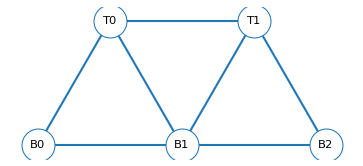

In [256]:
draw_truss(G, {L: 0.15})

We'll assume that the first and last nodes in the bottom row are fixed.

In [34]:
gset(G, fixed=['B0', f'B{N}'])

Now we'll loop through the nodes and assign a displacement vector to each one.
For the fixed nodes, the components of the displacement vector are 0.
For the other nodes, the components are SymPy symbols that represent the unknowns we will solve for.

In [39]:
for node in G.nodes():
    if node in G.graph['fixed']:
        ux, uy = 0, 0
    else:
        ux, uy = sp.symbols(f'u_{node}_x u_{node}_y')
        
    disp = make_vector(ux, uy, name=f'u_{node}')
    gset(G, node, disp=disp)

For reasons we'll see later, it will be convenient if every node has a unique index starting from `0`:

In [257]:
for i, node in enumerate(G.nodes):
    gset(G, node, index=i)

For this example, we'll assume that the roadway is attached to the bottom nodes.
To keep things simple, we'll ignore the weight of the truss itself and assume that the load it attached to a single node, `B1`.
The following loop creates a force vector for each node in the truss and assigns it to an attribute called `f_ext`.

In [259]:
F = sp.Symbol('F')
weighted = ['B1']

for node in G.nodes:
    if node in weighted:
        gset(G, node, f_ext=make_vector(0, -F))
    else:
        gset(G, node, f_ext=make_vector(0, 0))

Finally, we'll loop through the elements of the truss and assign each one these attributes

- `E`: Young's modulus,  
- `A`: cross-sectional area,
- `r`: a vector that represents the offset from one end of the element to the other,
- `l`: the length of the element,
- `k`: the spring constant, `E * A / l`



In [36]:
E, A = sp.symbols('E A')

for edge in G.edges:
    node1, node2 = edge
    x1 = G.nodes[node1]['pos']
    x2 = G.nodes[node2]['pos']

    r = x2 - x1
    l = r.norm()
    k = E * A / l

    gset(G, edge, E=E, A=A, r=r, l=l, k=k)

## Block Matrix Equation


In [43]:
def Ksym(i, j):
    return sp.MatrixSymbol(f'K_{i}{j}', 2, 2)

In [44]:
n = len(G.nodes)
blocks = [[Ksym(i, j) for j in range(n)] for i in range(n)]
K_block = sp.BlockMatrix(blocks)
K_block

Matrix([
[ K_00,  K_01,  K_02,  K_03,  K_04,  K_05,  K_06,  K_07,  K_08,  K_09,  K_010,  K_011,  K_012,  K_013,  K_014,  K_015,  K_016,  K_017,  K_018,  K_019,  K_020],
[ K_10,  K_11,  K_12,  K_13,  K_14,  K_15,  K_16,  K_17,  K_18,  K_19,  K_110,  K_111,  K_112,  K_113,  K_114,  K_115,  K_116,  K_117,  K_118,  K_119,  K_120],
[ K_20,  K_21,  K_22,  K_23,  K_24,  K_25,  K_26,  K_27,  K_28,  K_29,  K_210,  K_211,  K_212,  K_213,  K_214,  K_215,  K_216,  K_217,  K_218,  K_219,  K_220],
[ K_30,  K_31,  K_32,  K_33,  K_34,  K_35,  K_36,  K_37,  K_38,  K_39,  K_310,  K_311,  K_312,  K_313,  K_314,  K_315,  K_316,  K_317,  K_318,  K_319,  K_320],
[ K_40,  K_41,  K_42,  K_43,  K_44,  K_45,  K_46,  K_47,  K_48,  K_49,  K_410,  K_411,  K_412,  K_413,  K_414,  K_415,  K_416,  K_417,  K_418,  K_419,  K_420],
[ K_50,  K_51,  K_52,  K_53,  K_54,  K_55,  K_56,  K_57,  K_58,  K_59,  K_510,  K_511,  K_512,  K_513,  K_514,  K_515,  K_516,  K_517,  K_518,  K_519,  K_520],
[ K_60,  K_61,  K_62,  K_63,  K

In [45]:
blocks = [sp.MatrixSymbol(f'u_{{{node}}}', 2, 1) for node in G.nodes]
u_block = sp.BlockMatrix([[u] for u in blocks])
u_block

Matrix([
[ u_{B0}],
[ u_{B1}],
[ u_{B2}],
[ u_{B3}],
[ u_{B4}],
[ u_{B5}],
[ u_{B6}],
[ u_{B7}],
[ u_{B8}],
[ u_{B9}],
[u_{B10}],
[ u_{T0}],
[ u_{T1}],
[ u_{T2}],
[ u_{T3}],
[ u_{T4}],
[ u_{T5}],
[ u_{T6}],
[ u_{T7}],
[ u_{T8}],
[ u_{T9}]])

In [46]:
blocks = [sp.MatrixSymbol(f'f_{{{node}}}', 2, 1) for node in G.nodes]
f_block = sp.BlockMatrix([[f] for f in blocks])
f_block

Matrix([
[ f_{B0}],
[ f_{B1}],
[ f_{B2}],
[ f_{B3}],
[ f_{B4}],
[ f_{B5}],
[ f_{B6}],
[ f_{B7}],
[ f_{B8}],
[ f_{B9}],
[f_{B10}],
[ f_{T0}],
[ f_{T1}],
[ f_{T2}],
[ f_{T3}],
[ f_{T4}],
[ f_{T5}],
[ f_{T6}],
[ f_{T7}],
[ f_{T8}],
[ f_{T9}]])

In [47]:
equation = sp.Eq(K_block * u_block, f_block)
equation

Eq(Matrix([
[ K_00,  K_01,  K_02,  K_03,  K_04,  K_05,  K_06,  K_07,  K_08,  K_09,  K_010,  K_011,  K_012,  K_013,  K_014,  K_015,  K_016,  K_017,  K_018,  K_019,  K_020],
[ K_10,  K_11,  K_12,  K_13,  K_14,  K_15,  K_16,  K_17,  K_18,  K_19,  K_110,  K_111,  K_112,  K_113,  K_114,  K_115,  K_116,  K_117,  K_118,  K_119,  K_120],
[ K_20,  K_21,  K_22,  K_23,  K_24,  K_25,  K_26,  K_27,  K_28,  K_29,  K_210,  K_211,  K_212,  K_213,  K_214,  K_215,  K_216,  K_217,  K_218,  K_219,  K_220],
[ K_30,  K_31,  K_32,  K_33,  K_34,  K_35,  K_36,  K_37,  K_38,  K_39,  K_310,  K_311,  K_312,  K_313,  K_314,  K_315,  K_316,  K_317,  K_318,  K_319,  K_320],
[ K_40,  K_41,  K_42,  K_43,  K_44,  K_45,  K_46,  K_47,  K_48,  K_49,  K_410,  K_411,  K_412,  K_413,  K_414,  K_415,  K_416,  K_417,  K_418,  K_419,  K_420],
[ K_50,  K_51,  K_52,  K_53,  K_54,  K_55,  K_56,  K_57,  K_58,  K_59,  K_510,  K_511,  K_512,  K_513,  K_514,  K_515,  K_516,  K_517,  K_518,  K_519,  K_520],
[ K_60,  K_61,  K_62,  K_63,

In an ideal world, we would write the equation this way and solve it, but we don't have solvers that can work on a system where the elements are vectors and matrices.


## Compute the Block Matrix

Get the edge properties

In [48]:
edge = 'B1', 'T1'
r, k = gget(G, edge, "r", "k")

Get the displacements of the nodes

In [49]:
node1, node2 = edge
u1 = gget(G, node1, "disp")
u2 = gget(G, node2, "disp")

In [50]:
# Geometry and stiffness    
P = projector(r)

In [51]:
from sympy import MatMul

expr = MatMul(-k * P, u1 - u2, evaluate=False)
expr

Matrix([
[        -0.25*A*E/L, -0.25*sqrt(3)*A*E/L],
[-0.25*sqrt(3)*A*E/L,         -0.75*A*E/L]])*Matrix([
[u_B1_x - u_T1_x],
[u_B1_y - u_T1_y]])

In [52]:
# Internal force
f_int = -k * P * (u1 - u2)
f_int

Matrix([
[-0.25*A*E*(u_B1_x - u_T1_x)/L - 0.25*sqrt(3)*A*E*(u_B1_y - u_T1_y)/L],
[-0.25*sqrt(3)*A*E*(u_B1_x - u_T1_x)/L - 0.75*A*E*(u_B1_y - u_T1_y)/L]])

In [53]:
def compute_kP(G, edge):
    r, k = gget(G, edge, "r", "k")

    # Geometry and stiffness    
    P = projector(r)

    return k * P

In [54]:
def zero_block(size=2):
    return sp.ImmutableMatrix.zeros(size, size)

In [55]:
blocks = [[zero_block() for _ in range(n)] for _ in range(n)]

In [56]:
for edge in G.edges:
    kP = compute_kP(G, edge)
    
    node1, node2 = edge
    i = gget(G, node1, 'index')
    j = gget(G, node2, 'index')

    # Insert contributions for edge (i, j)
    blocks[i][i] +=  kP
    blocks[i][j] += -kP
    blocks[j][i] += -kP
    blocks[j][j] +=  kP

In [57]:
keep = [gget(G, node, 'index') 
        for node in G.nodes 
        if node not in G.graph['fixed']]
keep    

[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [58]:
blocks_reduced = [
    [blocks[i][j] for j in keep]
    for i in keep
]

In [59]:
K_block = sp.BlockMatrix(blocks_reduced)
K_block

Matrix([
[                                        Matrix([
[2.5*A*E/L,         0],
[        0, 1.5*A*E/L]]),                                                               Matrix([
[-A*E/L, 0],
[     0, 0]]),                                                                         Matrix([
[0, 0],
[0, 0]]),                                                                         Matrix([
[0, 0],
[0, 0]]),                                                                         Matrix([
[0, 0],
[0, 0]]),                                                                         Matrix([
[0, 0],
[0, 0]]),                                                                         Matrix([
[0, 0],
[0, 0]]),                                                                         Matrix([
[0, 0],
[0, 0]]),                                                                         Matrix([
[0, 0],
[0, 0]]), Matrix([
[       -0.25*A*E/L, 0.25*sqrt(3)*A*E/L],
[0.25*sqrt(3)*A*E/L,        -0.75*A*E/L]]), Matr

In [60]:
def get_block_vector(G, attr, keep):
    blocks = [gget(G, node, attr) for node in G.nodes]
    blocks_reduced = [[blocks[i]] for i in keep]
    return sp.BlockMatrix(blocks_reduced)

In [61]:
u_block = get_block_vector(G, 'disp', keep)
u_block

Matrix([
[Matrix([
[u_B1_x],
[u_B1_y]])],
[Matrix([
[u_B2_x],
[u_B2_y]])],
[Matrix([
[u_B3_x],
[u_B3_y]])],
[Matrix([
[u_B4_x],
[u_B4_y]])],
[Matrix([
[u_B5_x],
[u_B5_y]])],
[Matrix([
[u_B6_x],
[u_B6_y]])],
[Matrix([
[u_B7_x],
[u_B7_y]])],
[Matrix([
[u_B8_x],
[u_B8_y]])],
[Matrix([
[u_B9_x],
[u_B9_y]])],
[Matrix([
[u_T0_x],
[u_T0_y]])],
[Matrix([
[u_T1_x],
[u_T1_y]])],
[Matrix([
[u_T2_x],
[u_T2_y]])],
[Matrix([
[u_T3_x],
[u_T3_y]])],
[Matrix([
[u_T4_x],
[u_T4_y]])],
[Matrix([
[u_T5_x],
[u_T5_y]])],
[Matrix([
[u_T6_x],
[u_T6_y]])],
[Matrix([
[u_T7_x],
[u_T7_y]])],
[Matrix([
[u_T8_x],
[u_T8_y]])],
[Matrix([
[u_T9_x],
[u_T9_y]])]])

In [62]:
f_block = get_block_vector(G, 'f_ext', keep)
f_block

Matrix([
[Matrix([
[    0],
[f_ext]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])],
[        Matrix([
[0],
[0]])]])

## Make the arrays explicit

In [63]:
K_dense = K_block.as_explicit()
K_dense

Matrix([
[          2.5*A*E/L,                   0,              -A*E/L,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,        -0.25*A*E/L, 0.25*sqrt(3)*A*E/L,         -0.25*A*E/L, -0.25*sqrt(3)*A*E/L,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0],
[                  0,           1.5*A*E/L,                   0,                   0,                   0,                   0,                   0,                   0,                   0,    

In [64]:
u_dense = u_block.as_explicit()

In [65]:
f_dense = f_block.as_explicit()

In [66]:
Eq(MatMul(K_dense, u_dense, evaluate=False), f_dense)

Eq(Matrix([
[          2.5*A*E/L,                   0,              -A*E/L,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,        -0.25*A*E/L, 0.25*sqrt(3)*A*E/L,         -0.25*A*E/L, -0.25*sqrt(3)*A*E/L,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0,                   0],
[                  0,           1.5*A*E/L,                   0,                   0,                   0,                   0,                   0,                   0,                   0, 

In [67]:
eq = Eq(K_dense * u_dense, f_dense)

In [68]:
params = {
    'L': 15.0 * ureg.cm,
    'A': 1.0 * ureg.cm * 0.2 * ureg.cm,
    'E': 3.0e9 * ureg.Pa,
    'f_ext': -9.8 * ureg.newton,
}

In [69]:
syms = [L, A, E, f_ext]
subs = make_subs(syms, params)

In [70]:
eqs_num = eq.subs(subs)

In [71]:
sol = solve(eqs_num, u_dense)
sol

{u_B1_x: 0.0,
 u_B1_y: -0.000171500000000000,
 u_B2_x: 1.13160652761167e-5,
 u_B2_y: -0.000241733333333333,
 u_B3_x: 1.98031142332042e-5,
 u_B3_y: -0.000274400000000000,
 u_B4_x: 2.54611468712625e-5,
 u_B4_y: -0.000276033333333333,
 u_B5_x: 2.82901631902917e-5,
 u_B5_y: -0.000253166666666667,
 u_B6_x: 2.82901631902917e-5,
 u_B6_y: -0.000212333333333333,
 u_B7_x: 2.54611468712625e-5,
 u_B7_y: -0.000160066666666667,
 u_B8_x: 1.98031142332042e-5,
 u_B8_y: -0.000102900000000000,
 u_B9_x: 1.13160652761167e-5,
 u_B9_y: -4.73666666666667e-5,
 u_T0_x: 9.76010630065062e-5,
 u_T0_y: -8.57500000000000e-5,
 u_T1_x: 7.21399161352437e-5,
 u_T1_y: -0.000209883333333333,
 u_T2_x: 4.95077855830104e-5,
 u_T2_y: -0.000260516666666667,
 u_T3_x: 2.97046713498062e-5,
 u_T3_y: -0.000276850000000000,
 u_T4_x: 1.27305734356312e-5,
 u_T4_y: -0.000265416666666667,
 u_T5_x: -1.41450815951458e-6,
 u_T5_y: -0.000232750000000000,
 u_T6_x: -1.27305734356312e-5,
 u_T6_y: -0.000185383333333333,
 u_T7_x: -2.121762239271

In [72]:
Eq(u_block, u_block.subs(sol))

Eq(Matrix([
[Matrix([
[u_B1_x],
[u_B1_y]])],
[Matrix([
[u_B2_x],
[u_B2_y]])],
[Matrix([
[u_B3_x],
[u_B3_y]])],
[Matrix([
[u_B4_x],
[u_B4_y]])],
[Matrix([
[u_B5_x],
[u_B5_y]])],
[Matrix([
[u_B6_x],
[u_B6_y]])],
[Matrix([
[u_B7_x],
[u_B7_y]])],
[Matrix([
[u_B8_x],
[u_B8_y]])],
[Matrix([
[u_B9_x],
[u_B9_y]])],
[Matrix([
[u_T0_x],
[u_T0_y]])],
[Matrix([
[u_T1_x],
[u_T1_y]])],
[Matrix([
[u_T2_x],
[u_T2_y]])],
[Matrix([
[u_T3_x],
[u_T3_y]])],
[Matrix([
[u_T4_x],
[u_T4_y]])],
[Matrix([
[u_T5_x],
[u_T5_y]])],
[Matrix([
[u_T6_x],
[u_T6_y]])],
[Matrix([
[u_T7_x],
[u_T7_y]])],
[Matrix([
[u_T8_x],
[u_T8_y]])],
[Matrix([
[u_T9_x],
[u_T9_y]])]]), Matrix([
[                      Matrix([
[       0.0],
[-0.0001715]])],
[Matrix([
[  1.13160652761167e-5],
[-0.000241733333333333]])],
[    Matrix([
[1.98031142332042e-5],
[         -0.0002744]])],
[Matrix([
[  2.54611468712625e-5],
[-0.000276033333333333]])],
[Matrix([
[  2.82901631902917e-5],
[-0.000253166666666667]])],
[Matrix([
[  2.82901631902917e-5],


In [73]:
G_sol = G.copy()
scale = 300

for node in G_sol.nodes:
    pos = gget(G_sol, node, 'pos')
    u = gget(G_sol, node, 'disp')
    u_eval = u.subs(sol).evalf() * scale
    pos_new = pos + u_eval
    gset(G_sol, node, pos=pos_new)

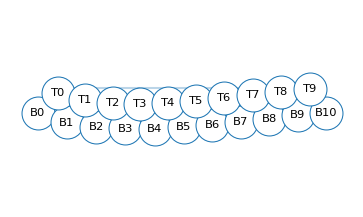

In [74]:
subs = {L: 0.15}
draw_truss(G, subs, label_nodes=False, alpha=0.3)
draw_truss(G_sol, subs)

## Discussion

When I was an undergraduate, I took a class where we learned to analyze trusses.
One of my classmates asked a question that I'm not sure I appreciated at the time, but it has stuck with me.
To paraphrase, he asked, "Do we design trusses because they are optimal, or because they are easy to analyze?"
I have come to realize tat this is a really good question.

As you might guess, the answer is both.
If your goal is to build a structure that supports a given load with a minimum amount of material, a truss may not be optimal -- with the complexity of real-world requirements and constraints, it's  generally impossible say what "optimal" even means.
But for many applications, a truss is a fundamentally good design.

It is also easy to analyze, but that is not as important as it used to be.
Before we had computers, we analyzed structures by hand, so we had to keep them simple.
When I was an undergraduate, we had enough compute power and software capability to analyze more complex structures, but what we could design was still limited by what we could analyze.

Now it is possible to analyze almost anything we can imagine, so analysis is no longer the limiting factor on what we can design and build.
But this is a recent change, and we are only beginning to see its consequences.

[Think Linear Algebra](https://allendowney.github.io/ThinkLinearAlgebra/index.html)

Copyright 2025 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)